# Implémentation du Fourier Neural Operator (FNO)

## Structure principale
- **Classe FNO1d** : Réseau neuronal pour résoudre l'équation de Kuramoto en 1D
- **Trois étapes** : Lifting, Couches de Fourier, Projection

## Composants clés
1. **Lifting** : Augmentation de la dimensionnalité de l'entrée
2. **Couches de Fourier** : 5 couches `SpectralConv1d` pour le traitement dans le domaine fréquentiel
3. **Convolutions locales et MLP** : Capture des interactions spatiales locales et globales
4. **Projection** : Deux couches de convolution 1D pour la réduction de dimensionnalité

## Particularités
- Combinaison de convolutions spectrales et spatiales
- Utilisation de skip connections pour améliorer le flux d'information
- Activation ELU pour un meilleur lissage des gradients
- `SpectralConv1d` personnalisée pour une convolution efficace dans le domaine de Fourier
- **Double couche de projection** : Permet une transition plus graduelle et une meilleure capture des caractéristiques complexes

## Note sur la double couche de projection
L'utilisation de deux couches de projection au lieu d'une seule offre plusieurs avantages :
1. **Transition graduelle** : Permet une réduction plus progressive de la dimensionnalité, évitant une perte brusque d'information.
2. **Capture de caractéristiques complexes** : La couche intermédiaire peut apprendre des représentations plus riches avant la projection finale.


In [ ]:
import os
import sys
import random
from typing import Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, ifftn, fftfreq
from scipy.fftpack import diff as psdiff
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%matplotlib inline


In [2]:
class SkipConnection(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SkipConnection, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class SpectralConv1d(nn.Module):
  def __init__(self, in_channels, out_channels,modes):
    """
    modes : number of fourier modes kept
    """
    super(SpectralConv1d, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.modes = modes
    self.scale = (1 / (in_channels*out_channels))

    self.weights = nn.Parameter(self.scale * torch.rand(self.in_channels, self.out_channels, self.modes, dtype=torch.cfloat))

  def complex_mult1d(self, input, w):
    return torch.einsum('bix,iox->box',input,w)

  def forward(self, x):
    #compute the fourier coefficients
    x_ft = torch.fft.rfft(x)
    # Use only relevant fourier modes
    # need to perform some slicing to select only the relevant parts
    #The real-to-complex FFT reduces the last dimension (Nx) to Nx//2 + 1
    #due to the symmetry in the Fourier transform of real-valued signals.

    out = torch.zeros(x.shape[0],self.out_channels,x.size(-1)//2+1,dtype=torch.cfloat).to(x.device)

    out[:,:,:self.modes] = self.complex_mult1d(x_ft[:,:,:self.modes],self.weights)
    out = torch.fft.irfft(out,n=x.size(-1))
    return out



In [18]:
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO1d(nn.Module):
  def __init__(self,modes,width,input_channels,output_channels):

    """
    The newtork consists of 4 Fourier Layers
    ->First we need to lift the input to the desired channel dim
    ->Then we apply the Fourier Layers
    ->Finally we need to project  the output back to the desired output space
    """
    super(FNO1d,self).__init__()

    self.modes = modes
    self.width = width
    self.input_channels = input_channels
    self.output_channels = output_channels
    #the output tensor from this layer will have a size of self.width
    #For now we will use a linear transformation
    self.lifting1 = nn.Conv1d(input_channels,self.width//2,1)
    self.lifting2 = nn.Conv1d(self.width//2,self.width,1)


    #define the Fourier Layers
    self.conv0 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv1 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv2 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv3 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv4 = SpectralConv1d(self.width,self.width,self.modes)
    #self.conv5 = SpectralConv1d(self.width,self.width,self.modes)

    #We still need to add the second half of the fourier layer which consists of

    #Mutliplying the input by a weight matrix and optionally adding a bias
    #We can either use conv1D or an MLP

    #Conv1d capture local features well but could miss out on capturing long-range
    #dependencies and complex nonlinear interactions that span the entire input space.

    ##MLP capture global interactions and complex relationships but might be less
    ## efficient and miss out on local detail refinements.

    ###In practice combining them both gives the best results
    self.w0 = nn.Conv1d(self.width, self.width, 1)
    self.w1 = nn.Conv1d(self.width, self.width,1)
    self.w2 = nn.Conv1d(self.width, self.width, 1)
    self.w3 = nn.Conv1d(self.width, self.width, 1)
    self.w4 = nn.Conv1d(self.width,self.width,1)
    #self.w5 = nn.Conv1d(self.width,self.width,1)

   

    #two layers to introduce non linearity
    self.projection1 = nn.Conv1d(self.width,self.width*2,1)
    self.projection2 = nn.Conv1d(self.width*2,output_channels,1)
    

  def forward(self,x):
      #First step : lift
      x = x.permute(0,2,1)
      x = self.lifting1(x)
      x = F.gelu(x)


      x = self.lifting2(x)
      x = F.gelu(x)
      # we need to permute because the next layer  expect the input to have the channels dimension second
      #x = x.permute(0,2,1)
      
      #2nd step : Fourier Layers
      x_skip = x
      x_0 = self.conv0(x)
      x_1 = self.w0(x)

      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      #x_skip = x
      x_0 = self.conv1(x)
      x_1 = self.w1(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      #x_skip = x
      x_0 = self.conv2(x)
      x_1 = self.w2(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      x_skip = x
      x_0 = self.conv3(x)
      x_1 = self.w3(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip
      
      x_skip = x
      x_0 = self.conv3(x)
      x_1 = self.w3(x)
      x = x_0 + x_1 + x_skip
      

      #3rd step : projection
      #x = x.permute(0,2,1)
      x = self.projection1(x)
      x = F.gelu(x)
      x = self.projection2(x)
      if self.output_channels == 1:
        x = x.permute(0,2,1)

      return x





# Préparation des données pour le Fourier Neural Operator (FNO)


**Création de paires 1-à-n** :
   - Fonction `create_1_to_n_pairs()` pour générer des séquences de sortie.
   - Utilisée lorsqu'on souhaite que le modèle prédise une séquence de `n` états futurs à partir d'un état initial.
   - Transforme les données d'origine en paires (entrée, séquence de sorties).


In [28]:

def sample_uniformly(inputs: np.ndarray, outputs: np.ndarray, num_samples: int) -> Tuple[np.ndarray, np.ndarray]:
    total_samples = inputs.shape[0]
    sampled_indices = random.sample(range(total_samples), num_samples)
    sampled_inputs = inputs[sampled_indices]
    sampled_outputs = outputs[sampled_indices]
    return sampled_inputs, sampled_outputs

def load_dataset(output_dir, dataset_type):
    inputs = np.load(os.path.join(output_dir, f'{dataset_type}_inputs.npy'))
    outputs = np.load(os.path.join(output_dir, f'{dataset_type}_outputs.npy'))
    return inputs, outputs

def create_1_to_n_pairs(inputs, outputs, n):
    new_inputs = []
    new_outputs = []
    
    num_samples = inputs.shape[0]
    
    for i in range(num_samples - n + 1):
        new_inputs.append(inputs[i])
        new_outputs.append(outputs[i:i+n])
    
    new_inputs = np.array(new_inputs)
    new_outputs = np.array(new_outputs)
    
    return new_inputs, new_outputs


output_dir = './ks_data'

# Load the datasets
print("Loading datasets...")
train_inputs = np.load(os.path.join(output_dir, 'train_inputs.npy'))
train_outputs = np.load(os.path.join(output_dir, 'train_outputs.npy'))
val_inputs = np.load(os.path.join(output_dir, 'val_inputs.npy'))
val_outputs = np.load(os.path.join(output_dir, 'val_outputs.npy'))

# Convert numpy arrays to PyTorch tensors
print("Converting numpy arrays to PyTorch tensors...")
train_inputs_tensor = torch.tensor(train_inputs, dtype=torch.float32)
train_outputs_tensor = torch.tensor(train_outputs, dtype=torch.float32)
val_inputs_tensor = torch.tensor(val_inputs, dtype=torch.float32)
val_outputs_tensor = torch.tensor(val_outputs, dtype=torch.float32)

# Parameters
n = 20  # Number of successive steps


# Ensure correct dimensions and types
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Train outputs shape: {train_outputs.shape}")
print(f"Validation inputs shape: {val_inputs.shape}")
print(f"Validation outputs shape: {val_outputs.shape}")


# Create 1-to-n pairs for the training set
train_inputs, train_outputs = create_1_to_n_pairs(train_inputs, train_outputs, n)
print(f"Created {train_inputs.shape[0]} 1-to-{n} pairs for training set.")

# Create 1-to-n pairs for the validation set
val_inputs, val_outputs = create_1_to_n_pairs(val_inputs, val_outputs, n)
print(f"Created {val_inputs.shape[0]} 1-to-{n} pairs for validation set.")


# Verify the new shapes
print(f"New train inputs shape: {train_inputs.shape}")
print(f"New train outputs shape: {train_outputs.shape}")
print(f"New val inputs shape: {val_inputs.shape}")
print(f"New val outputs shape: {val_outputs.shape}")









Loading datasets...
Converting numpy arrays to PyTorch tensors...
Train inputs shape: (240000, 256, 2)
Train outputs shape: (240000, 256)
Validation inputs shape: (20000, 256, 2)
Validation outputs shape: (20000, 256)
Created 239981 1-to-20 pairs for training set.
Created 19981 1-to-20 pairs for validation set.
New train inputs shape: (239981, 256, 2)
New train outputs shape: (239981, 20, 256)
New val inputs shape: (19981, 256, 2)
New val outputs shape: (19981, 20, 256)


In [29]:

num_samples_train = 50000
num_samples_val = 3000

# Uniformly sample 10,000 pairs from the training set
sampled_train_inputs, sampled_train_outputs = sample_uniformly(train_inputs, train_outputs, num_samples_train)


sampled_inputs_val, sampled_outputs_val = sample_uniformly(val_inputs, val_outputs, num_samples_val)


# Convert numpy arrays to PyTorch tensors
print("Converting numpy arrays to PyTorch tensors...")
sampled_train_inputs_tensor = torch.tensor(sampled_train_inputs, dtype=torch.float32)
sampled_train_outputs_tensor = torch.tensor(sampled_train_outputs, dtype=torch.float32)
sampled_val_inputs_tensor = torch.tensor(sampled_inputs_val, dtype=torch.float32)
sampled_val_outputs_tensor = torch.tensor(sampled_outputs_val, dtype=torch.float32)

# Create TensorDatasets
print("Creating TensorDatasets...")
train_dataset = TensorDataset(sampled_train_inputs_tensor, sampled_train_outputs_tensor)
val_dataset = TensorDataset(sampled_val_inputs_tensor, sampled_val_outputs_tensor)


# Create DataLoaders
batch_size = 50
print("Creating DataLoaders...")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(sampled_train_inputs_tensor.shape)
print(sampled_train_outputs_tensor.shape)


Converting numpy arrays to PyTorch tensors...
Creating TensorDatasets...
Creating DataLoaders...
torch.Size([50000, 256, 2])
torch.Size([50000, 20, 256])


Entraînement du Fourier Neural Operator (FNO)

   - Prédiction d'un état futur unique (t+1) : sauvegardé comme 'fno_model_single_step.pth'
   - Prédiction d'une séquence d'états (t+1 à t+20) : sauvegardé comme 'fno_model_sequence.pth'



In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

def train_fno(model, train_loader, val_loader, num_epochs, device, sequence_output=False):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(-1)
            
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': f'{loss.item():.6f}'})
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze(-1)
                
              
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        print(f"\n{'=' * 50}")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Validation Loss: {val_loss:.6f}")
        print(f"{'=' * 50}\n")

    return model

# Configuration
num_epochs = 30



Case 1: Single step prediction (t+1)


In [27]:
model_single = FNO1d(modes=32, width=64,input_channels=2,output_channels=1).to(device)
print("Training model for single step prediction (t+1)...")
model_single = train_fno(model_single, train_loader, val_loader, num_epochs, device)
torch.save(model_single.state_dict(), 'fno_model_single_step.pth')

Training model for single step prediction (t+1)...


Epoch 1/30:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 1000/1000 [00:36<00:00, 27.77it/s, train_loss=0.763476]



Epoch 1/30
Train Loss: 2.166618
Validation Loss: 0.752249



Epoch 2/30: 100%|██████████| 1000/1000 [00:34<00:00, 28.98it/s, train_loss=0.023285]



Epoch 2/30
Train Loss: 0.190030
Validation Loss: 0.023394



Epoch 3/30: 100%|██████████| 1000/1000 [00:33<00:00, 29.83it/s, train_loss=0.003311]



Epoch 3/30
Train Loss: 0.009946
Validation Loss: 0.003475



Epoch 4/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.52it/s, train_loss=0.001229]



Epoch 4/30
Train Loss: 0.001911
Validation Loss: 0.000661



Epoch 5/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.99it/s, train_loss=0.000653]



Epoch 5/30
Train Loss: 0.000971
Validation Loss: 0.000483



Epoch 6/30: 100%|██████████| 1000/1000 [00:33<00:00, 29.63it/s, train_loss=0.000781]



Epoch 6/30
Train Loss: 0.000882
Validation Loss: 0.000863



Epoch 7/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.60it/s, train_loss=0.002163]



Epoch 7/30
Train Loss: 0.001164
Validation Loss: 0.001968



Epoch 8/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.66it/s, train_loss=0.000920]



Epoch 8/30
Train Loss: 0.001412
Validation Loss: 0.000137



Epoch 9/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.75it/s, train_loss=0.000556]



Epoch 9/30
Train Loss: 0.001233
Validation Loss: 0.000144



Epoch 10/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.54it/s, train_loss=0.000361]



Epoch 10/30
Train Loss: 0.001179
Validation Loss: 0.000067



Epoch 11/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.73it/s, train_loss=0.000394]



Epoch 11/30
Train Loss: 0.000905
Validation Loss: 0.000113



Epoch 12/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.87it/s, train_loss=0.000315]



Epoch 12/30
Train Loss: 0.000849
Validation Loss: 0.000109



Epoch 13/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.96it/s, train_loss=0.001292]



Epoch 13/30
Train Loss: 0.000653
Validation Loss: 0.001582



Epoch 14/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.79it/s, train_loss=0.000428]



Epoch 14/30
Train Loss: 0.000544
Validation Loss: 0.000294



Epoch 15/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.93it/s, train_loss=0.000208]



Epoch 15/30
Train Loss: 0.000479
Validation Loss: 0.000037



Epoch 16/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.43it/s, train_loss=0.000206]



Epoch 16/30
Train Loss: 0.000225
Validation Loss: 0.000245



Epoch 17/30: 100%|██████████| 1000/1000 [00:24<00:00, 40.43it/s, train_loss=0.000433]



Epoch 17/30
Train Loss: 0.000220
Validation Loss: 0.000435



Epoch 18/30: 100%|██████████| 1000/1000 [00:24<00:00, 40.67it/s, train_loss=0.000052]



Epoch 18/30
Train Loss: 0.000240
Validation Loss: 0.000024



Epoch 19/30: 100%|██████████| 1000/1000 [00:22<00:00, 43.88it/s, train_loss=0.000034]



Epoch 19/30
Train Loss: 0.000085
Validation Loss: 0.000020



Epoch 20/30: 100%|██████████| 1000/1000 [00:22<00:00, 43.54it/s, train_loss=0.000090]



Epoch 20/30
Train Loss: 0.000078
Validation Loss: 0.000037



Epoch 21/30: 100%|██████████| 1000/1000 [00:25<00:00, 39.39it/s, train_loss=0.000038]



Epoch 21/30
Train Loss: 0.000050
Validation Loss: 0.000058



Epoch 22/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.00it/s, train_loss=0.000034]



Epoch 22/30
Train Loss: 0.000040
Validation Loss: 0.000018



Epoch 23/30: 100%|██████████| 1000/1000 [00:30<00:00, 33.05it/s, train_loss=0.000040]



Epoch 23/30
Train Loss: 0.000025
Validation Loss: 0.000020



Epoch 24/30: 100%|██████████| 1000/1000 [00:27<00:00, 35.81it/s, train_loss=0.000021]



Epoch 24/30
Train Loss: 0.000031
Validation Loss: 0.000015



Epoch 25/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.51it/s, train_loss=0.000015]



Epoch 25/30
Train Loss: 0.000018
Validation Loss: 0.000014



Epoch 26/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.64it/s, train_loss=0.000014]



Epoch 26/30
Train Loss: 0.000019
Validation Loss: 0.000014



Epoch 27/30: 100%|██████████| 1000/1000 [00:26<00:00, 38.16it/s, train_loss=0.000017]



Epoch 27/30
Train Loss: 0.000016
Validation Loss: 0.000014



Epoch 28/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.87it/s, train_loss=0.000014]



Epoch 28/30
Train Loss: 0.000015
Validation Loss: 0.000013



Epoch 29/30: 100%|██████████| 1000/1000 [00:26<00:00, 38.11it/s, train_loss=0.000016]



Epoch 29/30
Train Loss: 0.000015
Validation Loss: 0.000013



Epoch 30/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.22it/s, train_loss=0.000014]



Epoch 30/30
Train Loss: 0.000015
Validation Loss: 0.000013



Case 2: Sequence prediction (t+1 to t+20)


In [91]:
model_sequence = FNO1d(modes=32, width=64,input_channels=2,output_channels=20).to(device)
print("\nTraining model for sequence prediction (t+1 to t+20)...")
model_sequence = train_fno(model_sequence, train_loader, val_loader, num_epochs, device, sequence_output=True)
torch.save(model_sequence.state_dict(), 'fno_model_sequence.pth')


Training model for sequence prediction (t+1 to t+20)...


Epoch 1/30:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 1000/1000 [00:34<00:00, 29.34it/s, train_loss=1.411474]



Epoch 1/30
Train Loss: 1.940155
Validation Loss: 1.278771



Epoch 2/30: 100%|██████████| 1000/1000 [00:36<00:00, 27.12it/s, train_loss=0.052520]



Epoch 2/30
Train Loss: 0.410639
Validation Loss: 0.058924



Epoch 3/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.66it/s, train_loss=0.032220]



Epoch 3/30
Train Loss: 0.043783
Validation Loss: 0.033123



Epoch 4/30: 100%|██████████| 1000/1000 [00:36<00:00, 27.71it/s, train_loss=0.008510]



Epoch 4/30
Train Loss: 0.020446
Validation Loss: 0.009836



Epoch 5/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.80it/s, train_loss=0.001869]



Epoch 5/30
Train Loss: 0.004885
Validation Loss: 0.003219



Epoch 6/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.25it/s, train_loss=0.000862]



Epoch 6/30
Train Loss: 0.002070
Validation Loss: 0.002404



Epoch 7/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.64it/s, train_loss=0.000764]



Epoch 7/30
Train Loss: 0.001766
Validation Loss: 0.002204



Epoch 8/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.19it/s, train_loss=0.001470]



Epoch 8/30
Train Loss: 0.001722
Validation Loss: 0.002439



Epoch 9/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.03it/s, train_loss=0.000953]



Epoch 9/30
Train Loss: 0.001519
Validation Loss: 0.002116



Epoch 10/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.19it/s, train_loss=0.000843]



Epoch 10/30
Train Loss: 0.001383
Validation Loss: 0.002391



Epoch 11/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.11it/s, train_loss=0.000438]



Epoch 11/30
Train Loss: 0.001249
Validation Loss: 0.002044



Epoch 12/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.70it/s, train_loss=0.000822]



Epoch 12/30
Train Loss: 0.001183
Validation Loss: 0.002164



Epoch 13/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.53it/s, train_loss=0.000261]



Epoch 13/30
Train Loss: 0.001071
Validation Loss: 0.002120



Epoch 14/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.17it/s, train_loss=0.010544]



Epoch 14/30
Train Loss: 0.000962
Validation Loss: 0.002260



Epoch 15/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.42it/s, train_loss=0.000221]



Epoch 15/30
Train Loss: 0.000848
Validation Loss: 0.002085



Epoch 16/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.09it/s, train_loss=0.000200]



Epoch 16/30
Train Loss: 0.000804
Validation Loss: 0.001966



Epoch 17/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.91it/s, train_loss=0.000648]



Epoch 17/30
Train Loss: 0.000708
Validation Loss: 0.002404



Epoch 18/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.97it/s, train_loss=0.000157]



Epoch 18/30
Train Loss: 0.000684
Validation Loss: 0.001911



Epoch 19/30: 100%|██████████| 1000/1000 [00:35<00:00, 28.25it/s, train_loss=0.000148]



Epoch 19/30
Train Loss: 0.000644
Validation Loss: 0.001942



Epoch 20/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.25it/s, train_loss=0.000130]



Epoch 20/30
Train Loss: 0.000605
Validation Loss: 0.001908



Epoch 21/30: 100%|██████████| 1000/1000 [00:35<00:00, 28.41it/s, train_loss=0.000111]



Epoch 21/30
Train Loss: 0.000581
Validation Loss: 0.001902



Epoch 22/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.54it/s, train_loss=0.000170]



Epoch 22/30
Train Loss: 0.000559
Validation Loss: 0.001958



Epoch 23/30: 100%|██████████| 1000/1000 [00:31<00:00, 32.20it/s, train_loss=0.000197]



Epoch 23/30
Train Loss: 0.000552
Validation Loss: 0.002023



Epoch 24/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.76it/s, train_loss=0.000099]



Epoch 24/30
Train Loss: 0.000536
Validation Loss: 0.001894



Epoch 25/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.26it/s, train_loss=0.000088]



Epoch 25/30
Train Loss: 0.000529
Validation Loss: 0.001894



Epoch 26/30: 100%|██████████| 1000/1000 [00:34<00:00, 28.81it/s, train_loss=0.000130]



Epoch 26/30
Train Loss: 0.000519
Validation Loss: 0.001930



Epoch 27/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.96it/s, train_loss=0.000095]



Epoch 27/30
Train Loss: 0.000512
Validation Loss: 0.001887



Epoch 28/30: 100%|██████████| 1000/1000 [00:34<00:00, 28.60it/s, train_loss=0.000072]



Epoch 28/30
Train Loss: 0.000506
Validation Loss: 0.001886



Epoch 29/30: 100%|██████████| 1000/1000 [00:37<00:00, 26.58it/s, train_loss=0.000090]



Epoch 29/30
Train Loss: 0.000502
Validation Loss: 0.001887



Epoch 30/30: 100%|██████████| 1000/1000 [00:35<00:00, 28.53it/s, train_loss=0.000096]



Epoch 30/30
Train Loss: 0.000500
Validation Loss: 0.001885



Test

In [33]:
# Generate test dataset


def generate_params() -> Tuple[int, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns parameters for initial conditions.
    """
    N = 10
    lmin, lmax = 1, 3
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0 * np.pi * np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return N, A, phi, l

def initial_conditions(x: np.ndarray, L: int, params: Optional[list] = None) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    """
    if params is None:
        params = generate_params()
    N, A, phi, l = params
    u = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L) + phi), -1)
    return u

def pseudospectral(t: float, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for KS equation using Fourier transform.
    """
    u_x = psdiff(u, period=L)
    u_xx = psdiff(u, period=L, order=2)
    u_xxxx = psdiff(u, period=L, order=4)
    uu_x = u * u_x

    dudt = -uu_x - u_xx - u_xxxx
    return dudt

def generate_dataset_test(num_samples: int, L: int, N: int, T: float, tol: float, output_dir: str):
    x = np.linspace(0,  L, N)
    t = np.arange(0, T+0.05, 0.05)

    initial_conditions_list = []
    solutions_list = []

    for i in range(num_samples):
        u0 = initial_conditions(x, L)
        sol_ps = solve_ivp(fun=pseudospectral, t_span=[t[0], t[-1]], y0=u0, method='Radau', t_eval=t, args=(L,), atol=tol, rtol=tol)
        initial_conditions_list.append(u0)
        solutions_list.append(sol_ps.y.T)
        if i % 10 == 0:
            print(f"Generated {i} samples")

    initial_conditions_array = np.array(initial_conditions_list)
    max_len = max([sol.shape[0] for sol in solutions_list])
    solutions_array = np.zeros((num_samples, max_len, N))
    for i, sol in enumerate(solutions_list):
        solutions_array[i, :sol.shape[0], :] = sol

    return initial_conditions_array, solutions_array



# Parameters
L = 100
N = 256
T = 100
tol = 1e-6
num_samples = 1
test_initial_conditions, test_solutions = generate_dataset_test(num_samples, L, N, T, tol, output_dir)
# Generate validation dataset
#aggregate_datasets(1, 100, dt, L, N, output_dir, 'test')
#test_inputs = np.load(os.path.join(output_dir, 'test_inputs.npy'))
#test_outputs = np.load(os.path.join(output_dir, 'test_outputs.npy'))

#sampled_inputs_test, sampled_outputs_test = sample_uniformly(test_inputs, test_outputs, 1)





Generated 0 samples


Evaluating long sequence prediction...


C:\Users\FisherMoon25\AppData\Local\Temp\ipykernel_15828\739772957.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_long.load_state_dict(torch.load('fno_model_sequ

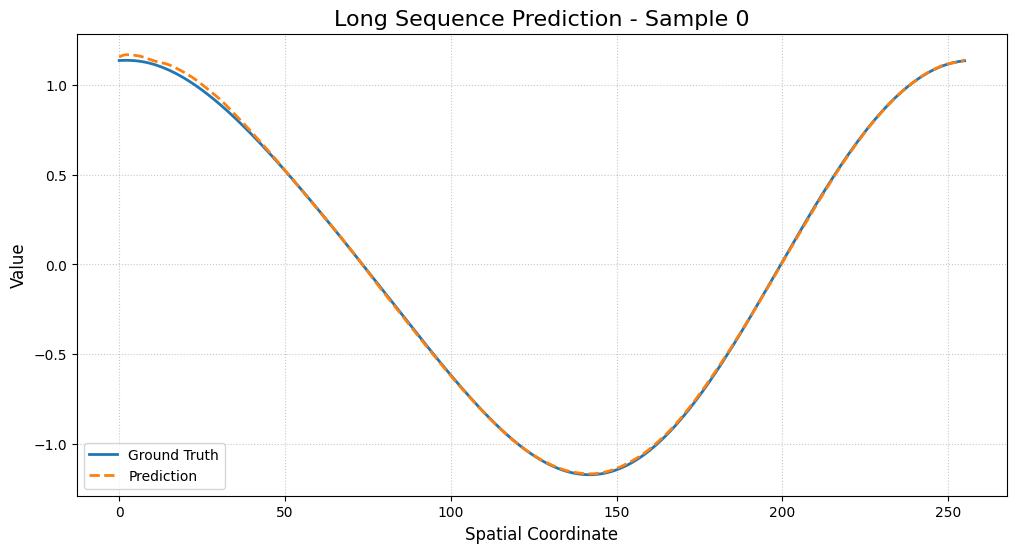


Evaluating single step prediction...


C:\Users\FisherMoon25\AppData\Local\Temp\ipykernel_15828\739772957.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


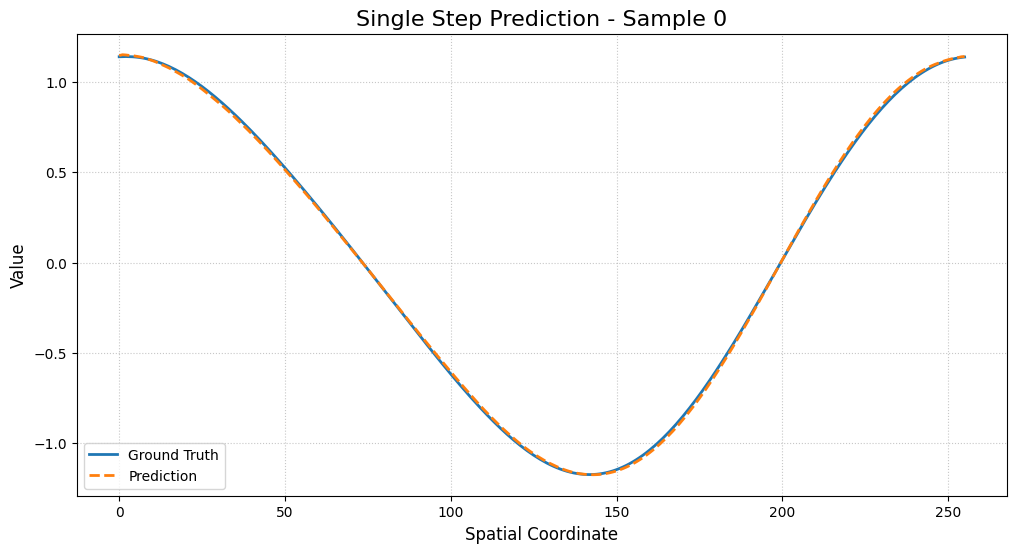

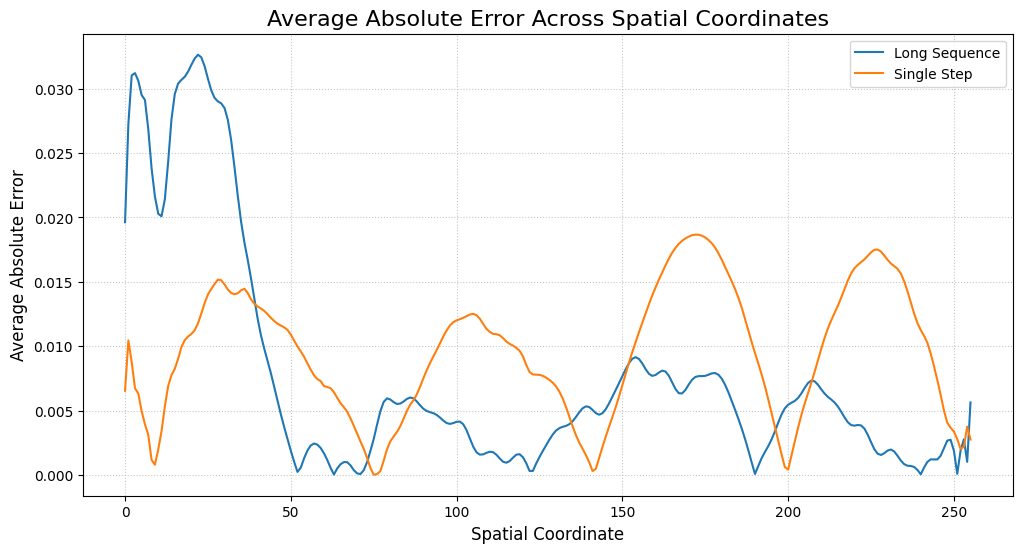

Visualization complete. Check the generated PNG files for detailed plots.


In [83]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data(test_initial_conditions, test_solutions, time_steps_to_predict, device):
    test_initial_conditions_tensor = torch.tensor(test_initial_conditions, dtype=torch.float32)
    test_solutions_tensor = torch.tensor(test_solutions[:, time_steps_to_predict-1, :], dtype=torch.float32)
    test_dataset = TensorDataset(test_initial_conditions_tensor, test_solutions_tensor)
    return DataLoader(test_dataset, batch_size=1, shuffle=False)

def load_model(model_path, device):
    model = FNO1d(modes=32, width=64, input_channels=2, output_channels=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict_long_sequence(model, inputs, time_steps_to_predict, device):
    predictions = []
    grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
    current_input = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)
    
    with torch.no_grad():
        while len(predictions) * 20 < time_steps_to_predict:
            outputs = model(current_input).squeeze().cpu().numpy()
            predictions.append(outputs)
            last_output = outputs[-1]
            last_output_tensor = torch.tensor(last_output, dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(-1)
            current_input = torch.cat((last_output_tensor, grid.expand_as(last_output_tensor)), dim=-1)
    
    return np.concatenate(predictions, axis=0)[:time_steps_to_predict]

def predict_single_step(model, inputs, device):
    with torch.no_grad():
        grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
        inputs = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)
        return model(inputs).squeeze().cpu().numpy()

def plot_comparison(ground_truth, prediction, title, save_path=None):
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth, label="Ground Truth", linewidth=2)
    plt.plot(prediction, label="Prediction", linewidth=2, linestyle='--')
    plt.title(title, fontsize=16)
    plt.xlabel("Spatial Coordinate", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.7)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_error_heatmap(ground_truth, predictions, title, save_path=None):
    error = np.abs(ground_truth - predictions)
    plt.figure(figsize=(12, 6))
    sns.heatmap(error.T, cmap='viridis', cbar_kws={'label': 'Absolute Error'})
    plt.title(title, fontsize=16)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Spatial Coordinate", fontsize=12)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Main execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
time_steps_to_predict = 10
# Long sequence prediction
print("Evaluating long sequence prediction...")
test_loader_long = load_and_prepare_data(test_initial_conditions, test_solutions, time_steps_to_predict, device)
#model_long = load_model('fno_model_longsequence.pth', device)
model_long = FNO1d(modes=32, width=64, input_channels=2, output_channels=20).to(device)
model_long.load_state_dict(torch.load('fno_model_sequence.pth'))
model_long.eval()
all_predictions_long = []
all_targets_long = []

for inputs, targets in test_loader_long:
    inputs, targets = inputs.to(device), targets.to(device)
    predictions = predict_long_sequence(model_long, inputs,time_steps_to_predict, device)
    all_predictions_long.append(predictions[-1])
    all_targets_long.append(targets.squeeze().cpu().numpy())

all_predictions_long = np.array(all_predictions_long)
all_targets_long = np.array(all_targets_long)

for idx in range(1):
    plot_comparison(all_targets_long[idx], all_predictions_long[idx], 
                    f"Long Sequence Prediction - Sample {idx}", 
                    f"long_sequence_comparison_{idx}.png")

#plot_error_heatmap(all_targets_long[0], all_predictions_long[0], 
#                   "Error Heatmap - Long Sequence Prediction",
#                   "long_sequence_error_heatmap.png")

# Single step prediction
print("\nEvaluating single step prediction...")
test_loader_single = load_and_prepare_data(test_initial_conditions, test_solutions, time_steps_to_predict, device)
model_single = load_model('fno_model_single_step.pth', device)

all_predictions_single = []
all_targets_single = []

for inputs, targets in test_loader_single:
    inputs, targets = inputs.to(device), targets.to(device)
    predictions = predict_single_step(model_single, inputs, device)
    all_predictions_single.append(predictions)
    all_targets_single.append(targets.squeeze().cpu().numpy())

all_predictions_single = np.array(all_predictions_single)
all_targets_single = np.array(all_targets_single)

for idx in range(1):
    plot_comparison(all_targets_single[idx], all_predictions_single[idx], 
                    f"Single Step Prediction - Sample {idx}",
                    f"single_step_comparison_{idx}.png")

#plot_error_heatmap(all_targets_single[0], all_predictions_single[0], 
#                   "Error Heatmap - Single Step Prediction",
#                   "single_step_error_heatmap.png")

# Additional visualizations
plt.figure(figsize=(12, 6))
plt.plot(np.mean(np.abs(all_targets_long - all_predictions_long), axis=0), label="Long Sequence")
plt.plot(np.mean(np.abs(all_targets_single - all_predictions_single), axis=0), label="Single Step")
plt.title("Average Absolute Error Across Spatial Coordinates", fontsize=16)
plt.xlabel("Spatial Coordinate", fontsize=12)
plt.ylabel("Average Absolute Error", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()



Single Step - Predictions shape: (1, 2000, 256)
Single Step - Targets shape: (1, 2000, 256)


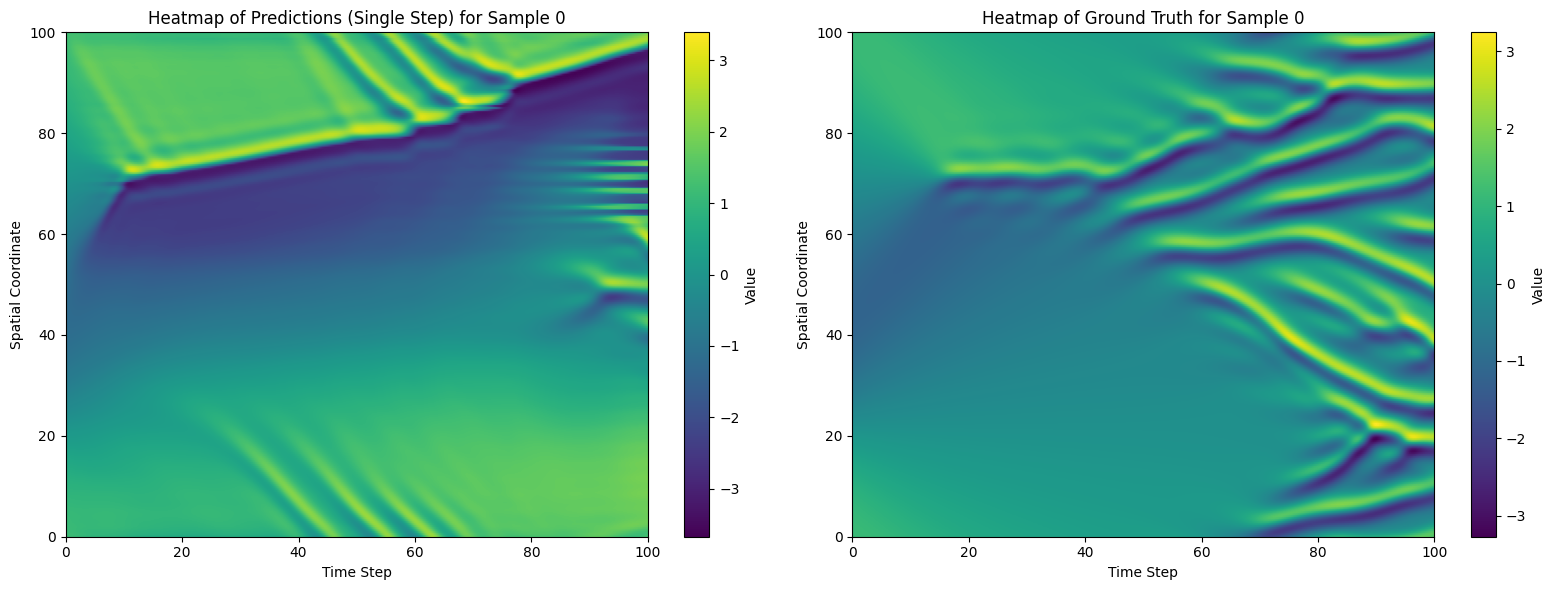

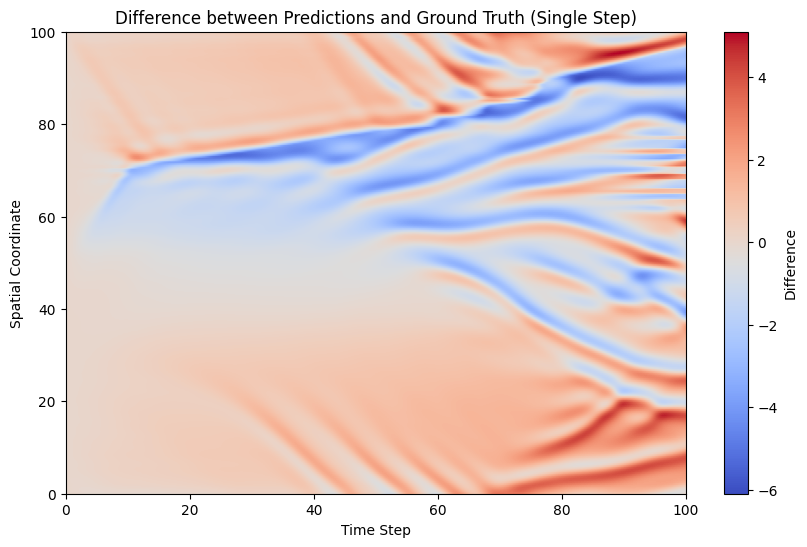

Sequence - Predictions shape: (1, 2000, 256)
Sequence - Targets shape: (1, 2000, 256)


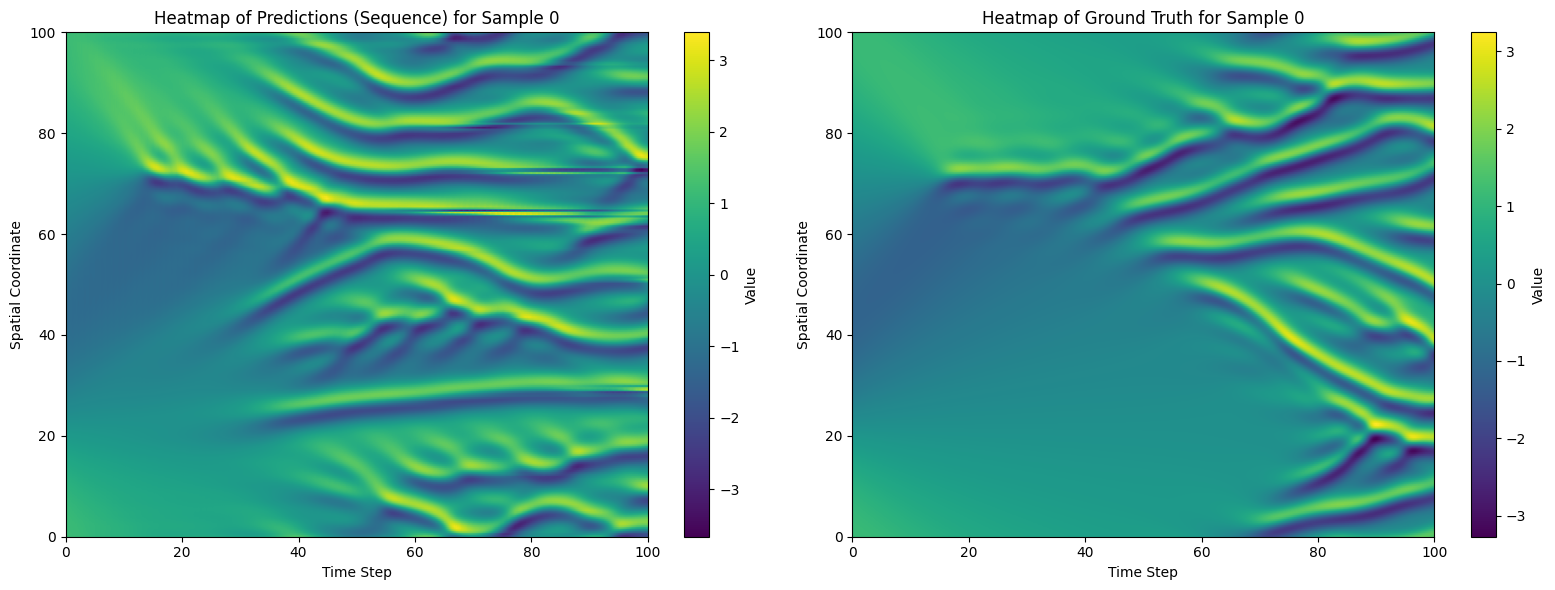

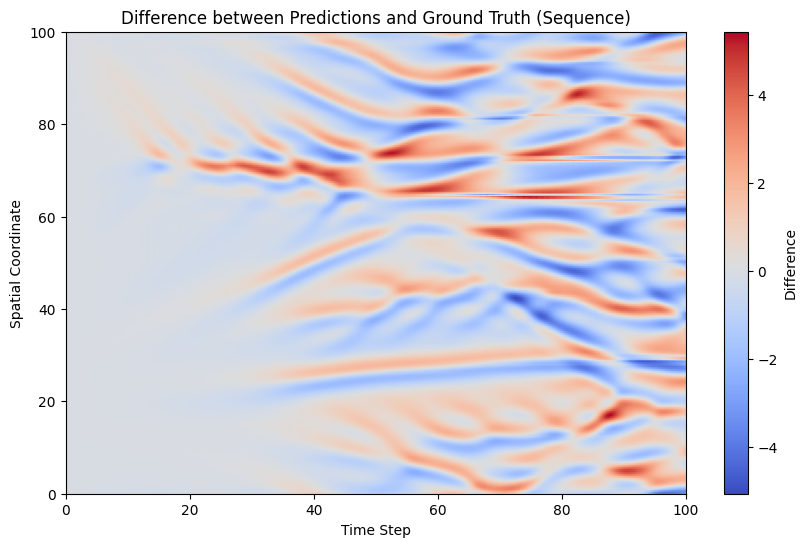

In [99]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt



def plot_heatmaps(predictions, targets, idx, model_name, time_steps, L):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot predictions
    ax = axes[0]
    cax = ax.imshow(predictions.T, aspect='auto', cmap='viridis',
                    extent=[0, 0.05*time_steps, 0, L])
    ax.set_title(f"Heatmap of Predictions ({model_name}) for Sample {idx}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Spatial Coordinate")
    fig.colorbar(cax, ax=ax, label='Value')

    # Plot ground truth
    ax = axes[1]
    cax = ax.imshow(targets.T, aspect='auto', cmap='viridis',
                    extent=[0, 0.05*time_steps, 0, L])
    ax.set_title(f"Heatmap of Ground Truth for Sample {idx}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Spatial Coordinate")
    fig.colorbar(cax, ax=ax, label='Value')

    plt.tight_layout()
    plt.savefig(f"{model_name}_heatmap_sample_{idx}.png", dpi=300, bbox_inches='tight')
    plt.show()

def predict_single_step_sequence(model, initial_input, time_steps, device):
    predictions = []
    current_input = initial_input

    for _ in range(time_steps):
        prediction = predict_single_step(model, current_input, device)
        predictions.append(prediction)
        current_input = torch.tensor(prediction, dtype=torch.float32).unsqueeze(0).to(device)

    return np.array(predictions)

# Main execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
L = 100  
time_steps = 2000

def load_and_prepare_heatmap_data(test_initial_conditions, test_solutions, time_steps, device):
    test_initial_conditions_tensor = torch.tensor(test_initial_conditions, dtype=torch.float32)
    test_solutions_tensor = torch.tensor(test_solutions[:, :time_steps, :], dtype=torch.float32)
    test_dataset = TensorDataset(test_initial_conditions_tensor, test_solutions_tensor)
    return DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load data
test_loader = load_and_prepare_heatmap_data(test_initial_conditions, test_solutions, time_steps, device)


# Evaluate models
models = {
    "Single Step": model_single,
    "Sequence": model_long
}
k = 0 
all_model_predictions = []
all_model_targets = []
for model_name, model in models.items():
    all_predictions = []
    all_targets = []

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        #grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
        #inputs = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)
        if k ==1:
            predictions = predict_long_sequence(model, inputs, time_steps, device)
        else :
            predictions = predict_single_step_sequence(model, inputs,time_steps, device)
            
        all_predictions.append(predictions)
        all_targets.append(targets.squeeze().cpu().numpy())
        
        k+=1
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_model_predictions.append(all_predictions)
    all_model_targets.append(all_targets)

    print(f"{model_name} - Predictions shape:", all_predictions.shape)
    print(f"{model_name} - Targets shape:", all_targets.shape)

    plot_heatmaps(all_predictions, all_targets, idx, model_name, time_steps, L)

    # Calculate and plot the difference between predictions and ground truth
    difference = all_predictions - all_targets
    plt.figure(figsize=(10, 6))
    plt.imshow(difference.T, aspect='auto', cmap='coolwarm', 
               extent=[0, 0.05*time_steps, 0, L])
    plt.title(f"Difference between Predictions and Ground Truth ({model_name})")
    plt.xlabel("Time Step")
    plt.ylabel("Spatial Coordinate")
    plt.colorbar(label='Difference')
    plt.show()




Analyzing correlations for Single Step Model
Predictions shape: (1, 2000, 256)
References shape: (1, 2000, 256)


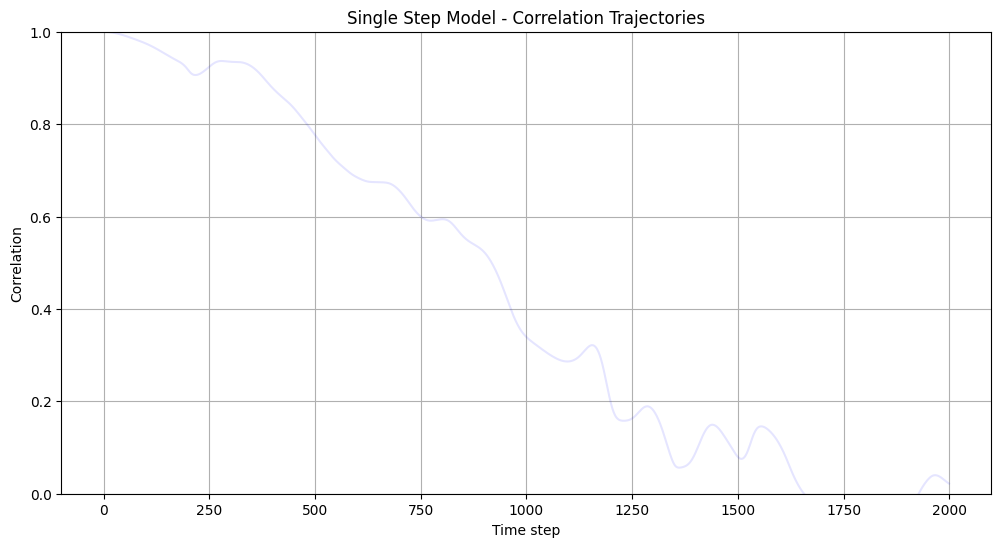


Correlation Statistics for Single Step Model:
Mean correlation: 0.4272
Standard deviation of correlation: 0.3711
Minimum correlation: -0.1308
Maximum correlation: 1.0000

Lowest mean correlation at time step: 1773
Highest mean correlation at time step: 0

Analyzing correlations for Sequence Model
Predictions shape: (1, 2000, 256)
References shape: (1, 2000, 256)


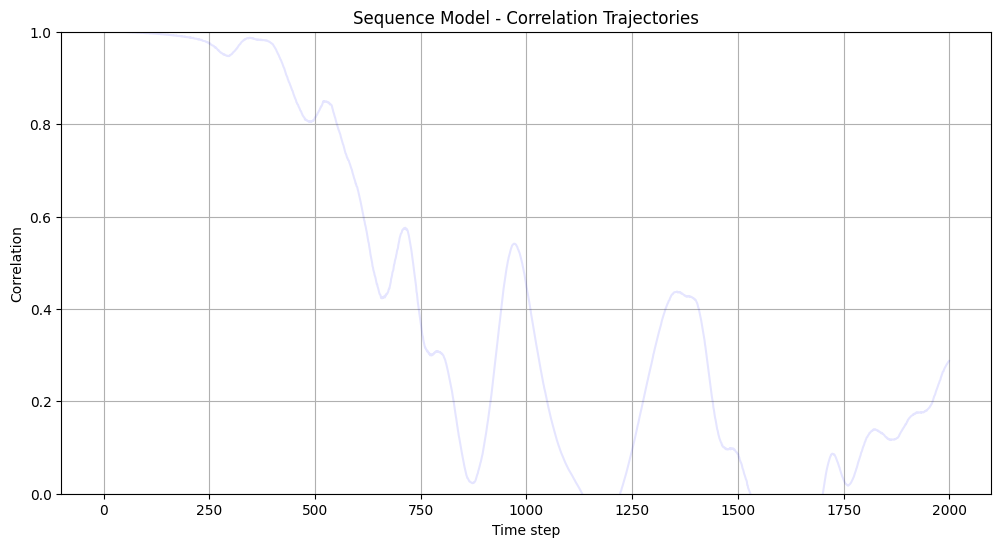


Correlation Statistics for Sequence Model:
Mean correlation: 0.4092
Standard deviation of correlation: 0.3844
Minimum correlation: -0.1911
Maximum correlation: 1.0000

Lowest mean correlation at time step: 1644
Highest mean correlation at time step: 5


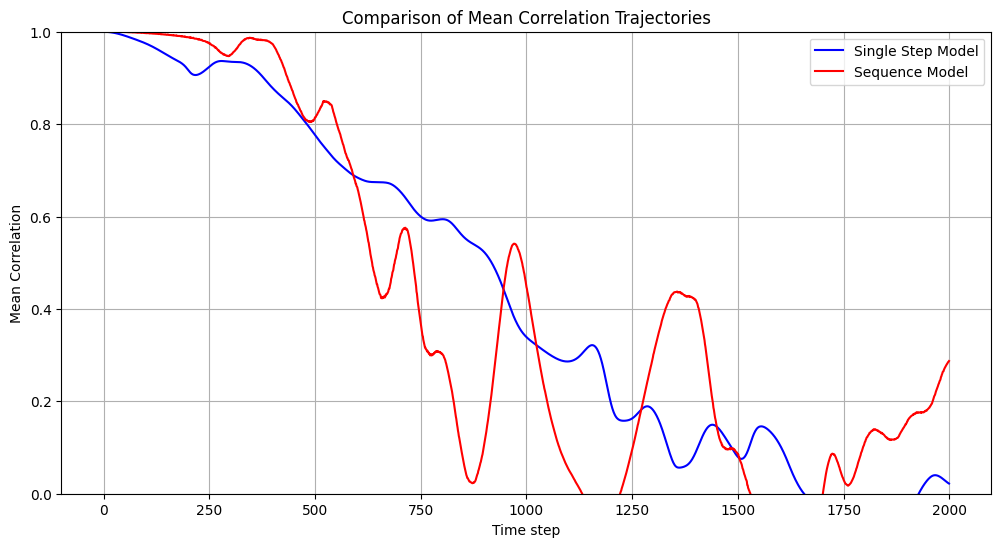

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def correlation(pred, ref):
    pred_normalized = pred / np.linalg.norm(pred)
    ref_normalized = ref / np.linalg.norm(ref)
    return np.dot(pred_normalized.flatten(), ref_normalized.flatten())

def compute_correlation_trajectories(predictions, references):
    corr_trajectories = np.zeros((predictions.shape[0], predictions.shape[1]))
    for i in range(predictions.shape[0]):
        for j in range(predictions.shape[1]):
            corr_trajectories[i, j] = correlation(predictions[i, j], references[i, j])
    return corr_trajectories

def plot_correlation_trajectories(corr_trajectories, title):
    plt.figure(figsize=(12, 6))
    plt.plot(corr_trajectories.T, alpha=0.1, color='blue')
    plt.ylim(0, 1)
    plt.title(f"{title} - Correlation Trajectories")
    plt.xlabel("Time step")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.savefig(f"{title.lower().replace(' ', '_')}_correlation_trajectories.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_mean_correlation_trajectory(corr_trajectories, title):
    mean_corr_trj = np.mean(corr_trajectories, axis=0)
    std_corr_trj = np.std(corr_trajectories, axis=0)
    sem_corr_trj = sem(corr_trajectories, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(mean_corr_trj, color='red', linewidth=2, label='Mean')
    plt.fill_between(range(len(mean_corr_trj)), 
                     mean_corr_trj - std_corr_trj, 
                     mean_corr_trj + std_corr_trj, 
                     alpha=0.3, color='red', label='±1 Std Dev')
    plt.fill_between(range(len(mean_corr_trj)), 
                     mean_corr_trj - sem_corr_trj, 
                     mean_corr_trj + sem_corr_trj, 
                     alpha=0.5, color='red', label='±1 SEM')
    plt.ylim(0, 1)
    plt.title(f"{title} - Mean Correlation Trajectory")
    plt.xlabel("Time step")
    plt.ylabel("Mean Correlation")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{title.lower().replace(' ', '_')}_mean_correlation_trajectory.png", dpi=300, bbox_inches='tight')
    plt.show()

def analyze_correlations(predictions, references, title):
    print(f"\nAnalyzing correlations for {title}")
    print(f"Predictions shape: {predictions.shape}")
    print(f"References shape: {references.shape}")

    corr_trajectories = compute_correlation_trajectories(predictions, references)
    
    plot_correlation_trajectories(corr_trajectories, title)
    if num_samples > 1:
        plot_mean_correlation_trajectory(corr_trajectories, title)

    # Additional analysis
    mean_corr = np.mean(corr_trajectories)
    std_corr = np.std(corr_trajectories)
    min_corr = np.min(corr_trajectories)
    max_corr = np.max(corr_trajectories)
    
    print(f"\nCorrelation Statistics for {title}:")
    print(f"Mean correlation: {mean_corr:.4f}")
    print(f"Standard deviation of correlation: {std_corr:.4f}")
    print(f"Minimum correlation: {min_corr:.4f}")
    print(f"Maximum correlation: {max_corr:.4f}")

    # Identify time steps with lowest and highest correlations
    mean_corr_trajectory = np.mean(corr_trajectories, axis=0)
    lowest_corr_step = np.argmin(mean_corr_trajectory)
    highest_corr_step = np.argmax(mean_corr_trajectory)

    print(f"\nLowest mean correlation at time step: {lowest_corr_step}")
    print(f"Highest mean correlation at time step: {highest_corr_step}")

    return corr_trajectories

# Main execution
single_step_corr = analyze_correlations(all_model_predictions[0], all_model_targets[0], "Single Step Model")
sequence_corr = analyze_correlations(all_model_predictions[1], all_model_targets[1] ,"Sequence Model")

# Compare the two models
plt.figure(figsize=(12, 6))
plt.plot(np.mean(single_step_corr, axis=0), label='Single Step Model', color='blue')
plt.plot(np.mean(sequence_corr, axis=0), label='Sequence Model', color='red')
plt.ylim(0, 1)
plt.title("Comparison of Mean Correlation Trajectories")
plt.xlabel("Time step")
plt.ylabel("Mean Correlation")
plt.legend()
plt.grid(True)
plt.show()


